Investigate the effect of school status on smartwatch wear rate

In [1]:
%load_ext autoreload
%autoreload 2

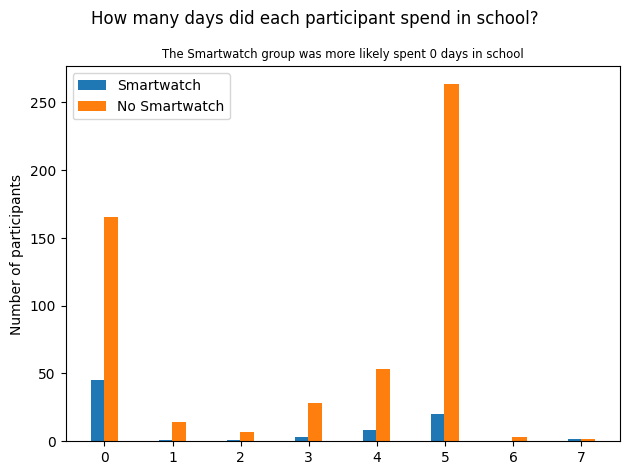

In [81]:
"""
Make a histogram of how many days each participant spent in school

"""
import numpy as np
import matplotlib.pyplot as plt

from ema import read

schooldays_with_watch = read.n_days_in_school(subset="smartwatch")
schooldays_no_watch = read.n_days_in_school(subset="not smartwatch")

fig, axis = plt.subplots()
bins1 = np.sort(np.concatenate([np.arange(8) - 0.2, np.arange(8) + 0.01]))
bins2 = np.sort(np.concatenate([np.arange(8) - 0.01, np.arange(8) + 0.2]))
axis.hist(schooldays_with_watch.values(), bins=bins1, label="Smartwatch")
axis.hist(schooldays_no_watch.values(), bins=bins2, label="No Smartwatch")

fig.suptitle("How many days did each participant spend in school?")
axis.set_title(
    "The Smartwatch group was more likely spent 0 days in school", fontsize="small"
)
axis.set_ylabel("Number of participants")
axis.legend()

fig.tight_layout()

fig.savefig("img/schooldays.png")

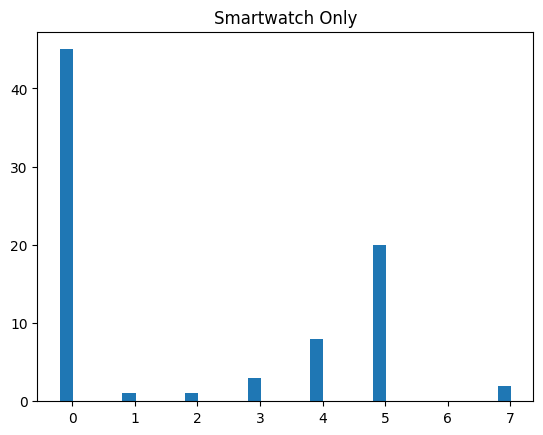

In [151]:
plt.hist(schooldays_with_watch.values(), bins=bins1)
plt.title("Smartwatch Only")

plt.savefig("img/schooldays_watch_only.png")

In [156]:
x = np.array(list(schooldays_with_watch.values()))
x = x[~(np.isnan(x) | (x == -99))]

np.unique(x, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 7.]), array([45,  1,  1,  3,  8, 20,  2]))

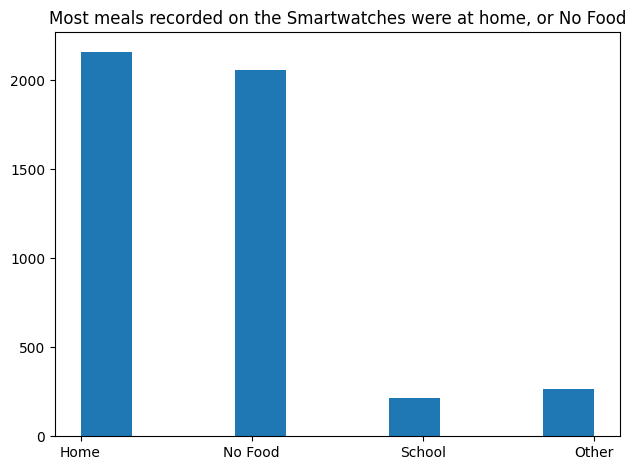

In [157]:
"""
Find what proportion of entries were at home/school/other, overall and as a function of how many days spent in school

"""
from ema import clean

meal_types = {"Meal", "Drink", "Snack", "No food/drink"}
meal_info = clean.cleaned_smartwatch(keep_catchups=False)

plt.hist(meal_info[meal_info["meal_type"].isin(meal_types)]["location"])

plt.xticks(plt.gca().get_xticks(), ["Home", "No Food", "School", "Other"])

plt.title("Most meals recorded on the Smartwatches were at home, or No Food")

plt.tight_layout()

plt.savefig("img/meal_locations.png")

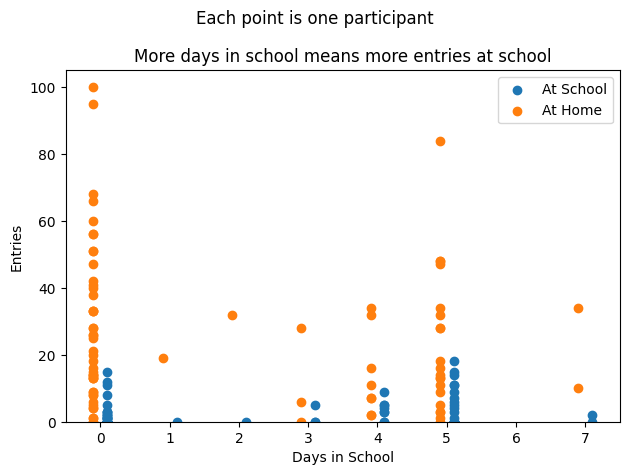

In [80]:
"""
Find the fraction of entries that were at school or at home for each participant and plot it against how many days they spent in school

"""
fig, axis = plt.subplots()

days_in_school = np.array(list(schooldays_with_watch.values()))
entries_in_school = np.zeros_like(days_in_school)
entries_at_home = np.zeros_like(days_in_school)

for i, participant in enumerate(schooldays_with_watch):
    df_slice = meal_info.query("p_id == @participant")

    # Find how many entries were at school
    n_in_school = (df_slice["location"] == "School").sum()

    # Find how many entries were at home
    n_at_home = (df_slice["location"] == "Home").sum()

    entries_in_school[i] = n_in_school
    entries_at_home[i] = n_at_home


axis.scatter(days_in_school + 0.1, entries_in_school, label="At School")
axis.scatter(days_in_school - 0.1, entries_at_home, label="At Home")
axis.set_xlim(-0.5, 7.5)
axis.set_ylim(0.0, axis.get_ylim()[1])
axis.set_xlabel("Days in School")
axis.set_ylabel("Entries")

axis.legend()

fig.suptitle("Each point is one participant")
axis.set_title("More days in school means more entries at school")

fig.tight_layout()

In [128]:
"""
Find the fraction of entries that were at home/school/other for each participant

"""
n_school = np.zeros(8)
n_home = np.zeros(8)
n_other = np.zeros(8)
n_no_response = np.zeros(8)
n_total = np.zeros(8)
for p_id in meal_info["p_id"].unique():
    # Find how many days the participant spent in school
    idx = schooldays_with_watch[p_id]

    if np.isnan(idx) or idx == -99:
        print(f"Skipping participant {p_id}")
        continue

    idx = int(idx)

    # Find the total for each participant
    df_slice = meal_info.query("p_id == @p_id")
    n_total[idx] += len(df_slice)

    # Find the total number of entries made in each location
    n_school[idx] += (df_slice["location"] == "School").sum()
    n_home[idx] += (df_slice["location"] == "Home").sum()
    n_other[idx] += (df_slice["location"] == "Elsewhere").sum()
    n_no_response[idx] += (df_slice["location"] == "No response").sum()


assert (
    n_total == n_school + n_home + n_other + n_no_response
).all(), f"{n_total}, {n_school}, {n_home}, {n_other}, {n_no_response}"

school_frac = n_school / n_total
home_frac = n_home / n_total
other_frac = n_other / n_total

Skipping participant 16231
Skipping participant 23158
Skipping participant 15439
Skipping participant 18604
Skipping participant 9891


/tmp/ipykernel_52895/214533521.py:35: RuntimeWarning: invalid value encountered in divide
  school_frac = n_school / n_total
/tmp/ipykernel_52895/214533521.py:36: RuntimeWarning: invalid value encountered in divide
  home_frac = n_home / n_total
/tmp/ipykernel_52895/214533521.py:37: RuntimeWarning: invalid value encountered in divide
  other_frac = n_other / n_total


Text(0, 0.5, 'Fraction of entries')

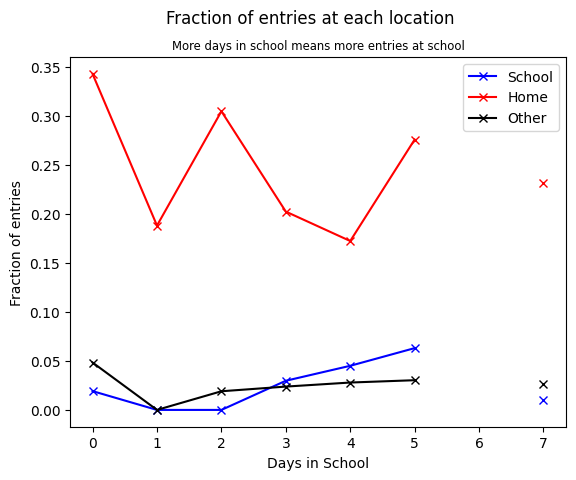

In [134]:
"""
Plot the fraction of entries that were at home/school/other for each participant

"""
days_in_school = np.arange(8)

fig, axis = plt.subplots()

axis.plot(days_in_school, school_frac, "bx-", label="School")
axis.plot(days_in_school, home_frac, "rx-", label="Home")
axis.plot(days_in_school, other_frac, "kx-", label="Other")

axis.legend()
fig.suptitle("Fraction of entries at each location")
axis.set_title("More days in school means more entries at school", fontsize="small")

axis.set_xlabel("Days in School")
axis.set_ylabel("Fraction of entries")

In [144]:
"""
Multi level model - we want to check if number of days in school affects the rate at which participants respond

"""
import pymc as pm
import pandas as pd

# Create a dataframe with the data we need
model_df = pd.DataFrame()
model_df["p_id"] = meal_info["p_id"]
model_df["days_in_school"] = meal_info["p_id"].map(schooldays_with_watch)


# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)

# Keep only valid values
keep = ~(model_df["days_in_school"].isna() | (model_df["days_in_school"] == -99))
model_df = model_df[keep]

print(model_df)


def linear_model(model_df: pd.DataFrame):
    # Define the model
    with pm.Model() as model:
        # Priors
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        schooldays_coef = pm.Normal("days_in_school", mu=0, sigma=10)
        p_id_sd = pm.HalfNormal("p_id_sd", sigma=10)
        p_id = pm.Normal("p_id", mu=0, sigma=p_id_sd, shape=model_df["p_id"].nunique())

        model_df["p_id"] = model_df["p_id"].astype("category").cat.codes

        # Expected value of outcome (using the logit link function)
        logit_p = intercept + schooldays_coef * model_df["days_in_school"] + p_id[model_df["p_id"]]

        # Likelihood
        entry = pm.Binomial(
            "entry", n=1, p=pm.math.invlogit(logit_p), observed=model_df["entry"]
        )

        # Fit the model
        trace = pm.sample(draws=2000, tune=1000, target_accept=0.95)

    return model, trace


# Print the summary
model, trace = linear_model(model_df)
pm.summary(trace)

                      p_id  days_in_school  entry
Datetime                                         
2021-11-30 08:02:05  20029             5.0      0
2021-11-30 08:02:19  16401             0.0      0
2021-11-30 09:04:05  20029             5.0      0
2021-11-30 09:04:19  16401             0.0      0
2021-11-30 10:05:06  20029             5.0      1
...                    ...             ...    ...
2022-07-26 16:12:14  39055             5.0      1
2022-07-26 17:12:20  39055             5.0      1
2022-07-26 18:14:20  39055             5.0      0
2022-07-26 19:14:24  39055             5.0      1
2022-07-26 20:14:34  39055             5.0      1

[6558 rows x 3 columns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, days_in_school, p_id_sd, p_id]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.781,0.149,0.495,1.054,0.006,0.004,640.0,956.0,1.0
days_in_school,-0.048,0.047,-0.134,0.041,0.002,0.001,902.0,1615.0,1.0
p_id[0],-0.180,0.272,-0.687,0.321,0.006,0.004,2350.0,4365.0,1.0
p_id[1],-1.305,0.242,-1.784,-0.877,0.005,0.004,2137.0,3791.0,1.0
p_id[2],0.339,0.272,-0.192,0.848,0.006,0.004,2032.0,3655.0,1.0
...,...,...,...,...,...,...,...,...,...
p_id[74],0.132,0.284,-0.399,0.671,0.005,0.004,2724.0,4290.0,1.0
p_id[75],0.005,0.251,-0.452,0.499,0.005,0.003,2875.0,4044.0,1.0
p_id[76],-0.723,0.326,-1.320,-0.103,0.006,0.004,3212.0,4764.0,1.0
p_id[77],-0.106,0.253,-0.573,0.377,0.006,0.004,1667.0,2733.0,1.0


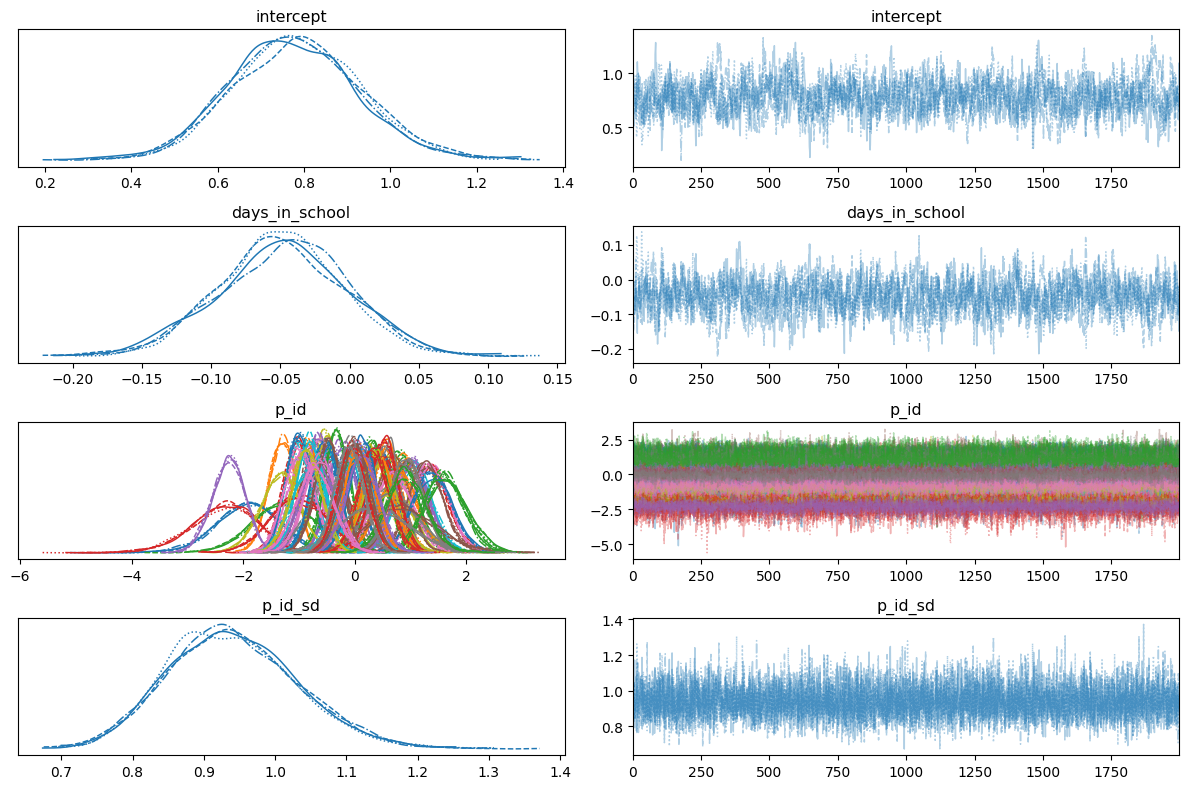

In [146]:
axes = pm.plot_trace(trace)
fig = axes.ravel()[0].get_figure()
fig.tight_layout()

mean           -0.048
sd              0.047
hdi_5%         -0.125
hdi_95%         0.028
mcse_mean       0.002
mcse_sd         0.001
ess_bulk      902.000
ess_tail     1615.000
r_hat           1.000
Name: days_in_school, dtype: float64


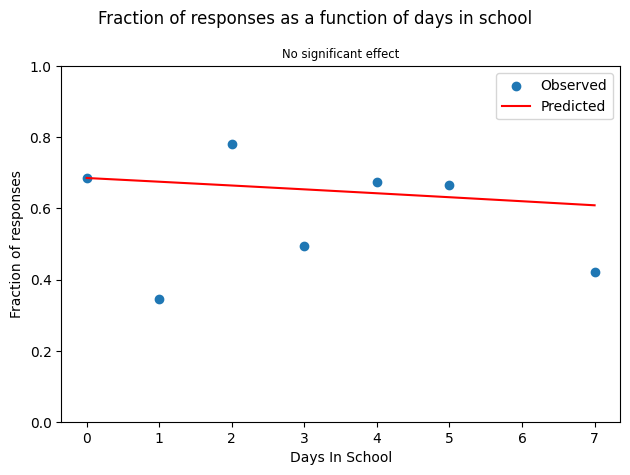

In [159]:
print(pm.summary(trace, hdi_prob=0.90).loc["days_in_school"])  # 95% HPD

fig, axis = plt.subplots()

# Group data by day and calculate mean of entry
grouped = model_df.groupby("days_in_school")["entry"].mean()

# Plot percentage of entries that equal 1
axis.scatter(grouped.index, grouped, label="Observed")

# Calculate predicted probabilities
days = np.arange(0, 8)
pred_probs = pm.invlogit(
    trace.posterior["intercept"].mean().item()
    + trace.posterior["days_in_school"].mean().item() * days
).eval()

# Plot predicted probabilities
axis.plot(days, pred_probs, color="red", label="Predicted")

axis.set_xlabel("Days In School")
axis.set_ylabel("Fraction of responses")

axis.set_ylim(0, 1)

axis.legend()

fig.suptitle("Fraction of responses as a function of days in school")
axis.set_title("No significant effect", fontsize="small")
fig.tight_layout()

fig.savefig("img/mlm_schooldays.png")